## Setup

In [1]:
import tensorflow as tf
import numpy as np
import math

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from util import import_dataset

address = '../../data/'
file_names = {}
file_names['images'] = 'full_data.npy'
file_names['subs'] = 'full_subredditlabels'
file_names['dict'] = 'full_subredditIndex'
file_names['nsfw'] = 'full_nsfwlabels'
data, dictionary = import_dataset(address, file_names)

In [3]:
print(data.X_train.shape)
print(data.X_val.shape)
print(data.X_test.shape)
print(data.y_train.shape)
print(data.y_val.shape)
print(data.y_test.shape)

(25450, 128, 128, 3)
(3181, 128, 128, 3)
(3182, 128, 128, 3)
(25450,)
(3181,)
(3182,)


### Balancing dataset (optional)

In [ ]:
from util import sample_data

subreddits = ['gonewild', 'ladybonersgw', 'PrettyGirls', 'LadyBoners']
dictionary_2 = sample_data(subreddits, data, dictionary)

## Run the Model

In [14]:
from googlenet import GoogleNetMulticlass
from config import ModelConfig, TrainConfig

tf.reset_default_graph()

model_config = ModelConfig(eval_batch_size=3000, learning_rate=3.77e-4, output="subreddit", sbrd_weight=0.8, keep_prob=0.967)
train_config = TrainConfig(print_every=100, num_epochs=50, saver_address=r'../../saved_params/', \
    save_file_name = 'GoogleNet_multitask_classification_4e-4_99', lr_decay=0.988)
model = GoogleNetMulticlass(model_config)
sess = tf.Session()
model.train(data, sess, train_config)

---------------------------------------------------------
Batch 100/398 of epoch 1 finished in 17.666859 seconds
Batch 200/398 of epoch 1 finished in 16.898689 seconds
Batch 300/398 of epoch 1 finished in 16.984218 seconds
Epoch 1 training finished in 68.041627 seconds
subreddit train accuracy:38.1%
nsfw train accuracy:92.1%
subreddit val accuracy:37.1%
nsfw val accuracy:92.1%
Epoch 1 evaluation finished in 11.259656 seconds
---------------------------------------------------------
Batch 100/398 of epoch 2 finished in 16.911366 seconds
Batch 200/398 of epoch 2 finished in 16.912999 seconds
Batch 300/398 of epoch 2 finished in 16.919500 seconds
Epoch 2 training finished in 67.287555 seconds
subreddit train accuracy:50.5%
nsfw train accuracy:90.9%
subreddit val accuracy:48.5%
nsfw val accuracy:90.1%
Epoch 2 evaluation finished in 11.198111 seconds
---------------------------------------------------------
Batch 100/398 of epoch 3 finished in 16.904200 seconds
Batch 200/398 of epoch 3 fini

## Load the Model

In [15]:
from googlenet import GoogleNetMulticlass
from config import ModelConfig, TrainConfig
import pickle

# Reset Graph
tf.reset_default_graph()

# Create model instance
model_config = ModelConfig(eval_batch_size=3000)
model = GoogleNetMulticlass(model_config)

# Load Saved Model
sess = tf.Session()
saver = tf.train.Saver()
save_file = "../../saved_params/GoogleNet_multitask_classification_4e-4_99"
saver.restore(sess, save_file) 
saved_history = pickle.load(open(save_file + "_modelhist", 'rb'))
model.model_history = saved_history

# Test Model Accuracy
loss_train, acc_sbrd_train, acc_nsfw_train = model.eval(data, sess, split='train')
loss_val, acc_sbrd_val, ac_nsfw_val = model.eval(data, sess, split = 'val')

subreddit train accuracy:93.6%
nsfw train accuracy:98.7%
subreddit val accuracy:64.1%
nsfw val accuracy:96.7%


## Plot Graph

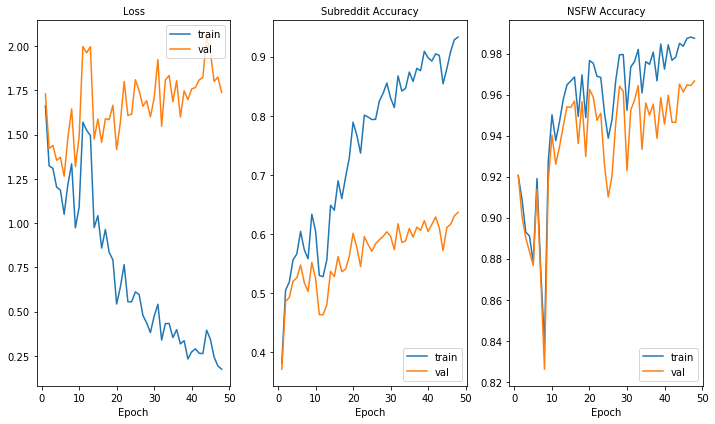

In [27]:
model.plot_loss_acc(data, save_address = "../../plots/")

## Hyperparameter Optimization

In [11]:
from googlenet import GoogleNetMulticlass
from config import ModelConfig, TrainConfig
import pickle
import hyperopt as hpropt

def objective(args):
    model_config = ModelConfig(learning_rate=args['learning_rate'], sbrd_weight=args['sbrd_weight'], keep_prob=args['keep_prob'])
    train_config = TrainConfig(num_epochs=args['num_epochs'], lr_decay=args['lr_decay'])
    
    tf.reset_default_graph()
    model = GoogleNetMulticlass(model_config)
    
    sess = tf.Session()
    model.train(data, sess, train_config)
    cost = model.model_history.best_val_cost
    accuracy_sbrd = model.model_history.best_val_acc[0]
    accuracy_nsfw = model.model_history.best_val_acc[1]
    
    saveList = {
        'accuracy_sbrd' : accuracy_sbrd,
        'accuracy_nsfw' : accuracy_nsfw,
        'cost' : cost,
        'num_epochs' : args['num_epochs'],
        'learning_rate' : args['learning_rate'],
        'lr_decay' : args['lr_decay'],
        'sbrd_weight' : args['sbrd_weight'],
        'keep_prob' : args['keep_prob']
    }
    print(saveList)
    pickle.dump(saveList, open("../../hprOpt/multi_{}_{}.dat".format(accuracy_sbrd, accuracy_nsfw), "wb"))
    model.plot_loss_acc(data)
    return cost

def optimize(space, max_evals=50):
    best = hpropt.fmin(objective, space, algo=hpropt.tpe.suggest, max_evals=max_evals)
    print(best)
    return best

---------------------------------------------------------
Batch 100/398 of epoch 1 finished in 18.775457 seconds
Batch 200/398 of epoch 1 finished in 17.126889 seconds
Batch 300/398 of epoch 1 finished in 17.087821 seconds
Epoch 1 training finished in 70.273977 seconds
subreddit train accuracy:33.8%
nsfw train accuracy:92.5%
subreddit val accuracy:33.4%
nsfw val accuracy:93.5%
Epoch 1 evaluation finished in 19.064750 seconds
---------------------------------------------------------
Batch 100/398 of epoch 2 finished in 17.084757 seconds
Batch 200/398 of epoch 2 finished in 17.079753 seconds
Batch 300/398 of epoch 2 finished in 17.024269 seconds
Epoch 2 training finished in 67.856104 seconds
subreddit train accuracy:41.2%
nsfw train accuracy:93.1%
subreddit val accuracy:39.5%
nsfw val accuracy:94.0%
Epoch 2 evaluation finished in 11.226853 seconds
---------------------------------------------------------
Batch 100/398 of epoch 3 finished in 17.065834 seconds
Batch 200/398 of epoch 3 fini

KeyboardInterrupt: 

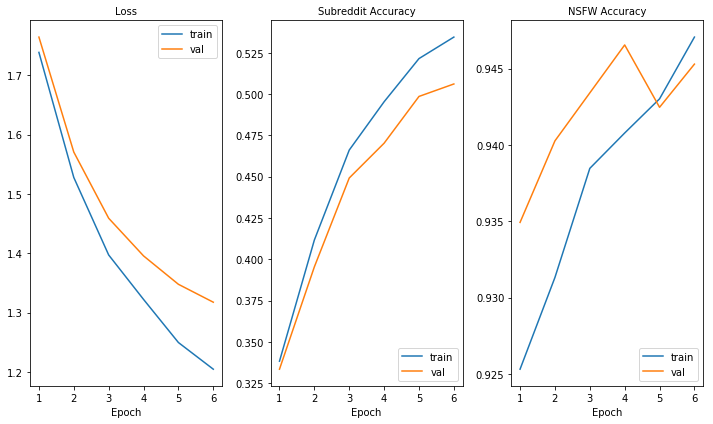

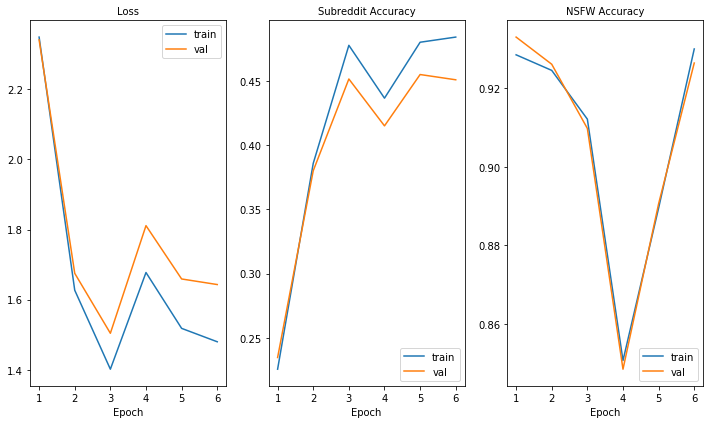

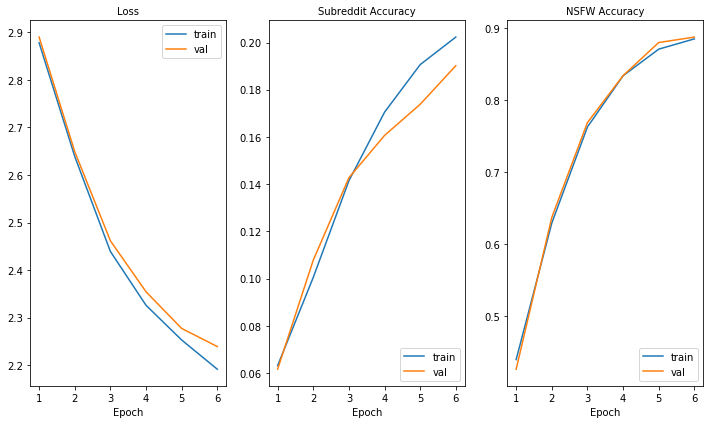

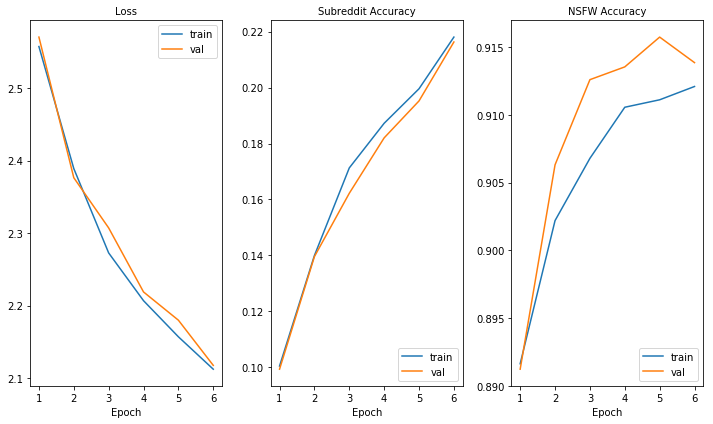

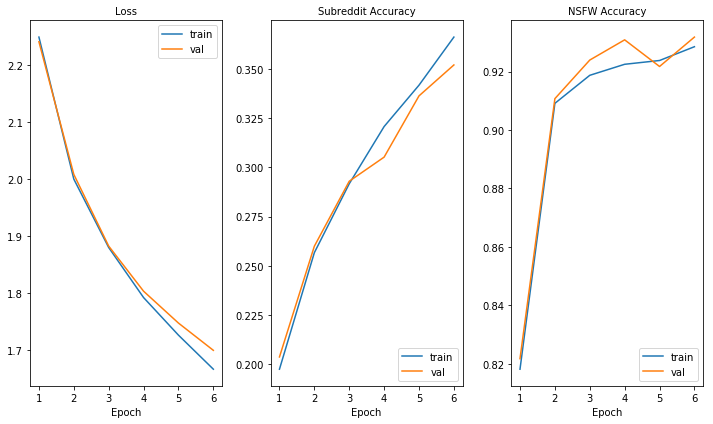

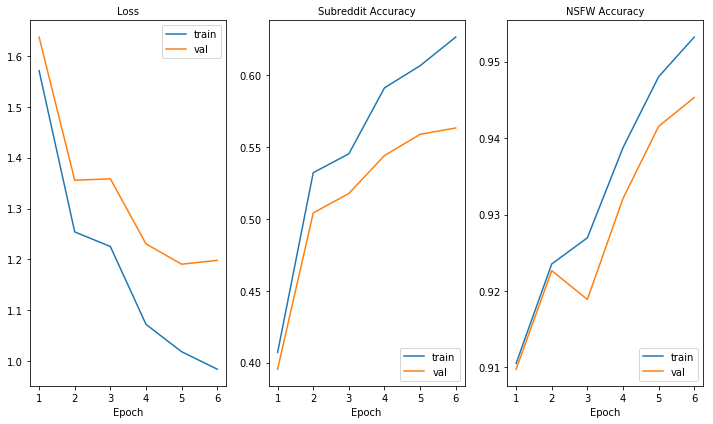

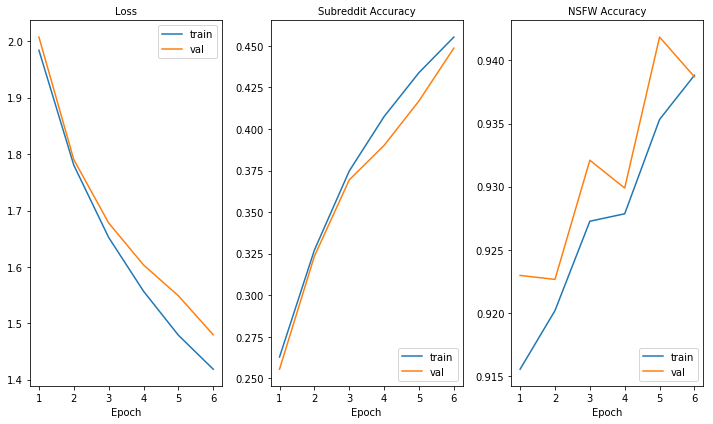

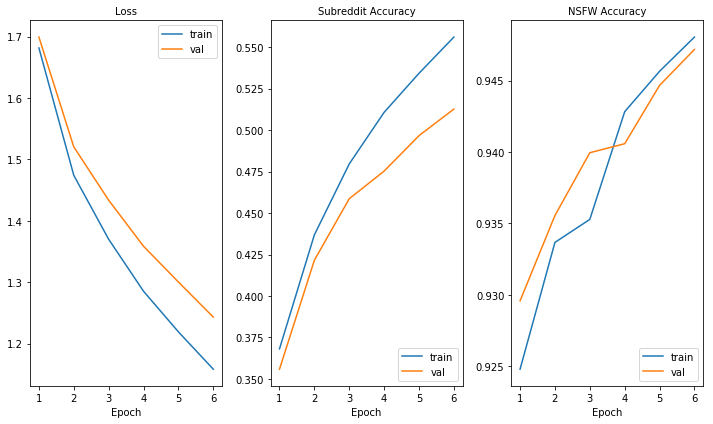

In [12]:
import math

def get_learning_rate_range(base_10_min, base_10_max):
    scale_factor = 1 / math.log10(math.e)
    return hpropt.hp.loguniform('learning_rate', scale_factor * base_10_min, scale_factor * base_10_max)

space = {
        'num_epochs' : 6,
        'learning_rate' : get_learning_rate_range(-6, -2),
        'lr_decay' : hpropt.hp.uniform('lr_decay', 0.9, 1.0),
        'sbrd_weight' : 0.8,
        'keep_prob' : hpropt.hp.uniform('keep_prob', 0.6, 1.0)
}
best_opt = optimize(space, 30)

## Evaluate on Test Set

In [17]:
# Get model predictions
y_test_sbrd_pred, y_test_nsfw_pred = sess.run(model.prediction, {model.X_placeholder: data.X_test, \
                                                               model.y_sbrd_placeholder: data.y_test, \
                                                               model.y_nsfw_placeholder: data.y_test_2, \
                                                               model.is_training_placeholder:False})
y_test_sbrd_pred = np.argmax(y_test_sbrd_pred, axis = 1)
y_test_nsfw_pred = np.argmax(y_test_nsfw_pred, axis = 1)

Normalized confusion matrix


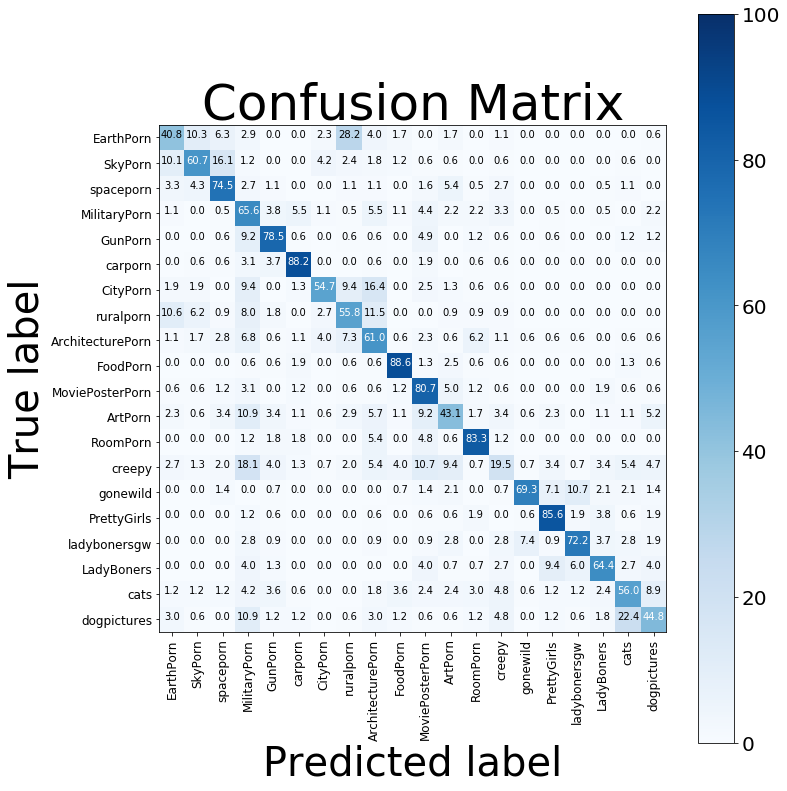

In [32]:
from util import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

classes_sbrd = sorted(dictionary, key=dictionary.get)
cm_sbrd = confusion_matrix(data.y_test, y_test_sbrd_pred)
plot_confusion_matrix(cm_sbrd, classes_sbrd, normalize=True, save_address = "../../plots/multitask_", \
                      save_name="sbrd_confusion_mat")

Normalized confusion matrix


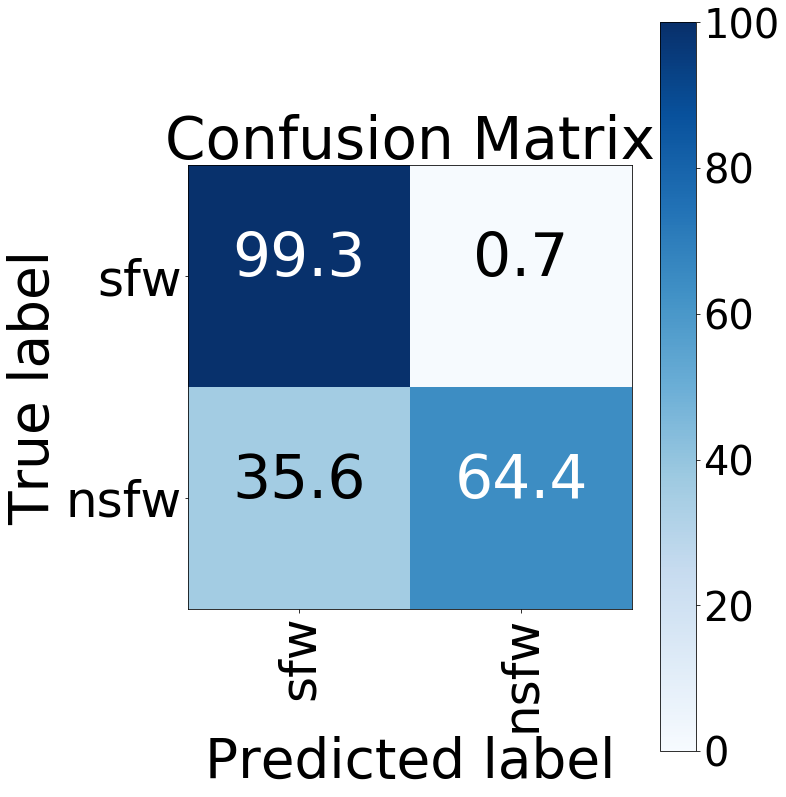

In [33]:
classes_nsfw = ["sfw", "nsfw"]
cm_nsfw = confusion_matrix(data.y_test_2, y_test_nsfw_pred)
plot_confusion_matrix(cm_nsfw, classes_nsfw, normalize=True, task="nsfw", save_address = "../../plots/multitask_", \
                     save_name="nsfw_confusion_mat")

In [31]:
from util import get_f1_score

sbrd_f1_score = get_f1_score(data.y_test, y_test_sbrd_pred)
nsfw_f1_score = get_f1_score(data.y_test_2, y_test_nsfw_pred)
print(sbrd_f1_score)
print(nsfw_f1_score)

0.639030224205
0.864434219496


In [34]:
_ = model.eval(data, sess, split="test")

subreddit test accuracy:64.4%
nsfw test accuracy:96.1%
